In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import evaluate_on_ticker
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef

# Prepare Model

In [4]:
@tf.autograph.experimental.do_not_convert
def last_step_accuracy(Y_true, Y_pred):
    last_step_labels = tf.dtypes.cast(Y_true[:, -1], tf.int32)
    last_step_preds = Y_pred[:,-1]
    last_step_preds = tf.math.argmax(last_step_preds, axis=1, output_type=tf.int32)
    compare = tf.dtypes.cast(tf.equal(last_step_preds, last_step_labels), tf.int32)
    tot_correct = tf.reduce_sum(compare)
    tot_size = tf.size(last_step_labels)
    accuracy = tf.divide(tot_correct, tot_size)
    return accuracy

MODEL_NAME = "beta_1"
model = tf.keras.models.load_model("models/{}".format(MODEL_NAME), custom_objects={'last_step_accuracy': last_step_accuracy})

# 1. By hours

In [7]:
ticker = 'GOOG'
START_DATE = '2022-10-1'
END_DATE = '2022-11-3'
FIG_SIZE = (10,5)
result = evaluate_on_ticker(model, ticker, START_DATE, END_DATE, conf_thresholds=[0,0.7,0.9])

result['Hour'] = result['Time'].apply(lambda timestamp: timestamp.hour)

def extract_accuracy(df):
    acc_df = pd.DataFrame(columns=['Hour', 'Accuracy'])
    acc_score = accuracy_score(df['Actual'], df['Prediction'])
    timestamp = df['Hour'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_mcc(df):
    acc_df = pd.DataFrame(columns=['Hour', 'MCC'])
    acc_score = matthews_corrcoef(df['Actual'], df['Prediction'])
    timestamp = df['Hour'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_metric(metric):
    def fit_df(df):
        metric_df = pd.DataFrame(columns=['Hour', 'Down', 'Up', 'Same'])
        metric_score = metric(df['Actual'], df['Prediction'], average=None)
        metric_df.loc[0] = [int(df['Hour'].iloc[0])] + [metric_score[i] for i in range(3)]
        return metric_df
    return fit_df

For predictions with confidence >= 0%, accuracy = 0.68
	 - 1766/1766 (100.00%) of all predictions
	 - 249/1766 (14.10%) of which have labels of val 0 (down)
	 - 196/1766 (11.10%) of which have labels of val 1 (up)
	 - 1321/1766 (74.80%) of which have labels of val 2 (same)
Performance:
              precision    recall  f1-score   support

        Down       0.59      0.43      0.50       346
          Up       0.62      0.35      0.45       348
Approx. Same       0.71      0.87      0.78      1072

    accuracy                           0.68      1766
   macro avg       0.64      0.55      0.58      1766
weighted avg       0.67      0.68      0.66      1766

MCC: 0.37699060361866515
For predictions with confidence >= 70.0%, accuracy = 0.80
	 - 825/1766 (46.72%) of all predictions
	 - 90/825 (10.91%) of which have labels of val 0 (down)
	 - 76/825 (9.21%) of which have labels of val 1 (up)
	 - 659/825 (79.88%) of which have labels of val 2 (same)
Performance:
              precision   

### Accuracy

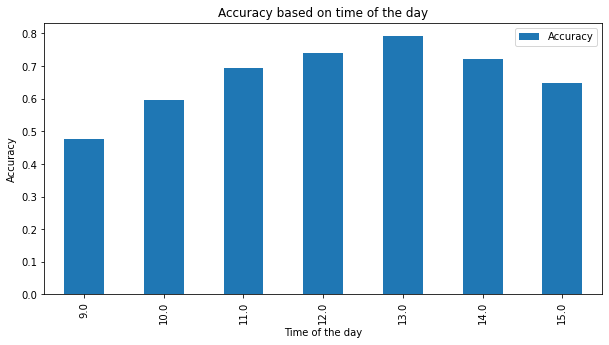

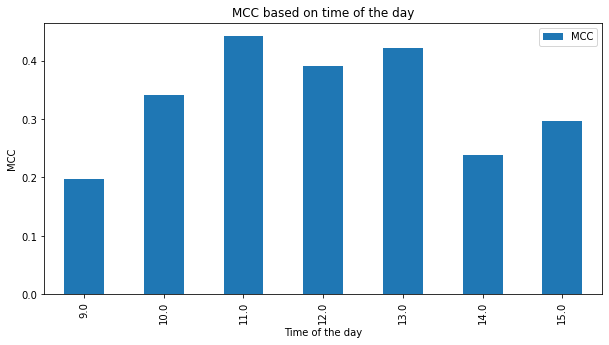

In [9]:
acc_df = result.groupby('Hour').apply(extract_accuracy)
acc_df.plot(x='Hour', y='Accuracy', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Accuracy")
plt.title("Accuracy based on time of the day")
plt.show()


mcc_df = result.groupby('Hour').apply(extract_mcc)
mcc_df.plot(x='Hour', y='MCC', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("MCC")
plt.title("MCC based on time of the day")
plt.show()

### Precision

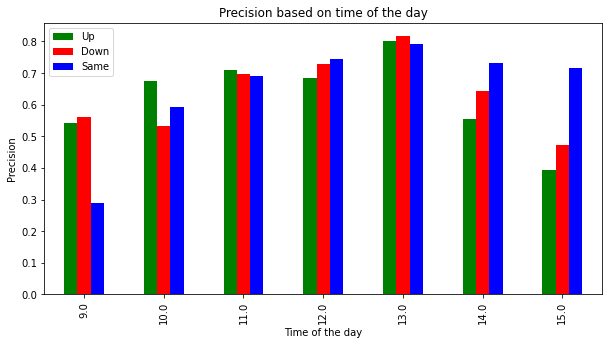

In [34]:
pre_df = result.groupby('Hour').apply(extract_metric(precision_score))
pre_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Precision")
plt.title("Precision based on time of the day")
plt.show()

### Recall

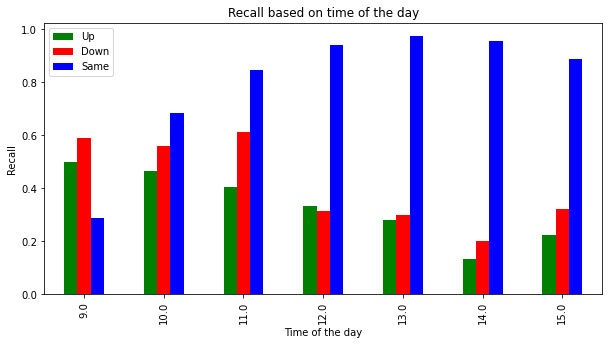

In [35]:
rec_df = result.groupby('Hour').apply(extract_metric(recall_score))
rec_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Recall")
plt.title("Recall based on time of the day")
plt.show()

## By Days

In [36]:
names_dayofweek = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
result['Dayofweek'] = result['Time'].apply(lambda timestamp: names_dayofweek[timestamp.dayofweek])

def extract_accuracy(df):
    acc_df = pd.DataFrame(columns=['Dayofweek', 'Accuracy'])
    acc_score = accuracy_score(df['Actual'], df['Prediction'])
    timestamp = df['Dayofweek'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_metric(metric):
    def fit_df(df):
        metric_df = pd.DataFrame(columns=['Dayofweek', 'Down', 'Up', 'Same'])
        metric_score = metric(df['Actual'], df['Prediction'], average=None)
        metric_df.loc[0] = [df['Dayofweek'].iloc[0]] + [metric_score[i] for i in range(3)]
        return metric_df
    return fit_df



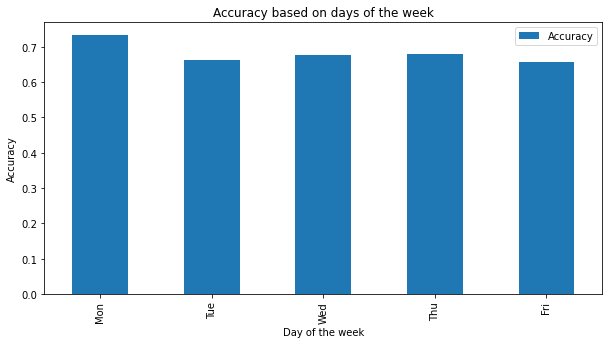

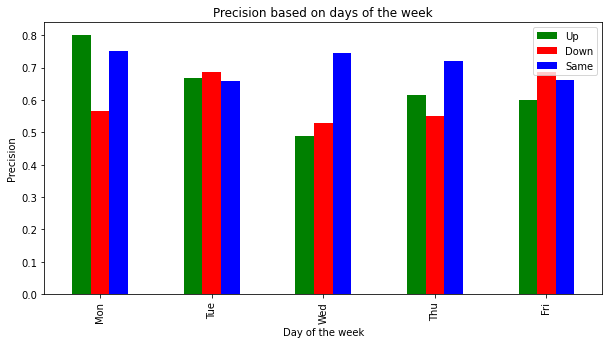

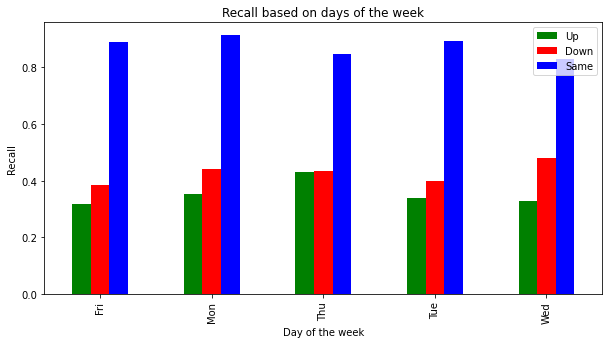

In [37]:
acc_df = result.groupby('Dayofweek').apply(extract_accuracy)

mapping = {day: i for i, day in enumerate(names_dayofweek)}
key = acc_df['Dayofweek'].map(mapping)
acc_df = acc_df.iloc[key.argsort()]

acc_df.plot(x='Dayofweek', y='Accuracy', kind='bar', figsize=(10,5))
plt.xlabel("Day of the week")
plt.ylabel("Accuracy")
plt.title("Accuracy based on days of the week")
plt.show()



pre_df = result.groupby('Dayofweek').apply(extract_metric(precision_score))

mapping = {day: i for i, day in enumerate(names_dayofweek)}
key = pre_df['Dayofweek'].map(mapping)
pre_df = pre_df.iloc[key.argsort()]

pre_df.plot(x='Dayofweek', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Day of the week")
plt.ylabel("Precision")
plt.title("Precision based on days of the week")
plt.show()



rec_df = result.groupby('Dayofweek').apply(extract_metric(recall_score))
rec_df.plot(x='Dayofweek', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Day of the week")
plt.ylabel("Recall")
plt.title("Recall based on days of the week")
plt.show()